## Coincident Index (Dynamic Factor Model)
Based on the statsmodels example: 
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html

Several attempts of estimating the parameters was done, starting from simpler models, to reaching the equivalent model use in statsmodel notebook. Obtaining quite good results.

Next step will be able to construct the coincident index in the PyMC framework

In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm
import pytensor

In [2]:
# 2. Download the data
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2014, 12, 31)

In [3]:
indprod = DataReader("IPMAN", "fred", start=start, end=end)
income = DataReader("W875RX1", "fred", start=start, end=end)
sales = DataReader("CMRMTSPL", "fred", start=start, end=end)
emp = DataReader("PAYEMS", "fred", start=start, end=end)

In [4]:
data = pd.concat((indprod, income, sales, emp), axis=1)
data.columns = ["indprod", "income", "sales", "emp"]
data.index.freq = data.index.inferred_freq

In [5]:
print(data.head())

            indprod  income       sales    emp
DATE                                          
1979-01-01  47.1722  5248.7  561382.192  88808
1979-02-01  47.3093  5278.5  558729.039  89055
1979-03-01  47.5389  5294.3  574897.892  89479
1979-04-01  46.7402  5242.7  559387.521  89417
1979-05-01  47.3949  5227.5  571771.305  89789


In [6]:
print(data.shape)

(432, 4)


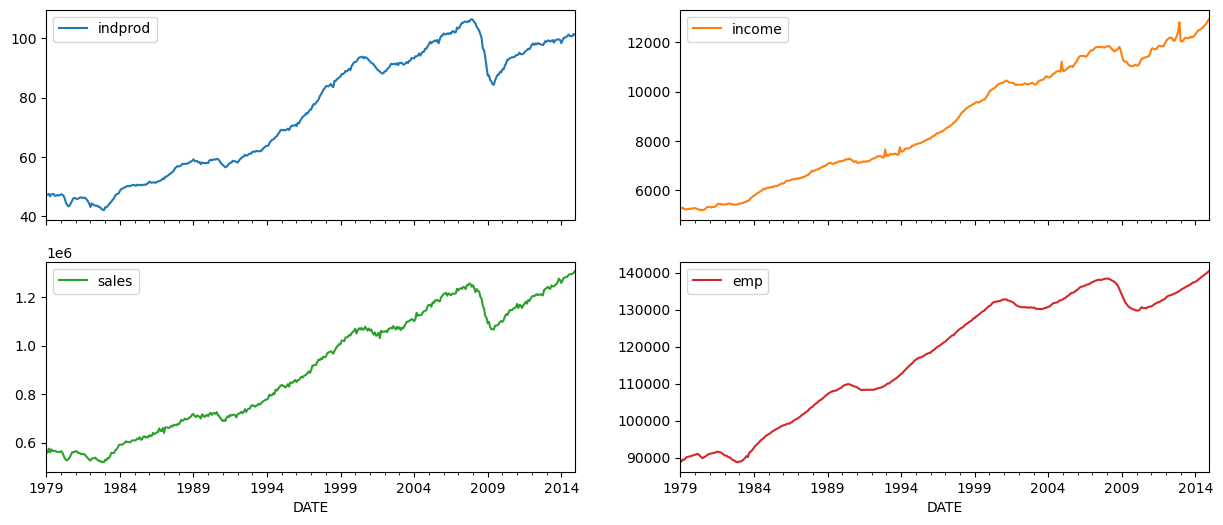

In [7]:
data.loc[:, "indprod":"emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

### Cointegration

In [8]:
def johansen_cointegration_test(df, det_order=-1, k_ar_diff=1):
    """
    Perform Johansen cointegration test
    det_order: Deterministic trend assumption (-1 to 3)
    k_ar_diff: Lag order for differencing (usually 1)
    """
    print("Johansen Cointegration Test Results")
    coint_test = coint_johansen(df.dropna(), det_order, k_ar_diff)

    trace_stat = coint_test.lr1
    crit_values = coint_test.cvt

    for i in range(len(trace_stat)):
        print(f"Rank {i}: Trace Statistic = {trace_stat[i]:.2f}, 90% CV = {crit_values[i, 0]:.2f}, 95% CV = {crit_values[i, 1]:.2f}, 99% CV = {crit_values[i, 2]:.2f}")
        if trace_stat[i] > crit_values[i, 1]:
            print("=> Reject H0: Cointegration rank >=", i)
        else:
            print("=> Fail to reject H0: Cointegration rank <", i)
        print()


In [9]:
coint_data = (data[['indprod', 'income', 'sales', 'emp']])
johansen_cointegration_test(coint_data)

Johansen Cointegration Test Results
Rank 0: Trace Statistic = 85.23, 90% CV = 37.03, 95% CV = 40.17, 99% CV = 46.57
=> Reject H0: Cointegration rank >= 0

Rank 1: Trace Statistic = 27.72, 90% CV = 21.78, 95% CV = 24.28, 99% CV = 29.51
=> Reject H0: Cointegration rank >= 1

Rank 2: Trace Statistic = 6.23, 90% CV = 10.47, 95% CV = 12.32, 99% CV = 16.36
=> Fail to reject H0: Cointegration rank < 2

Rank 3: Trace Statistic = 1.36, 90% CV = 2.98, 95% CV = 4.13, 99% CV = 6.94
=> Fail to reject H0: Cointegration rank < 3



The Johansen test indicates the presence of 2 cointegrating relationships among the 4 time series. This means there are 2 independent stationary linear combinations (cointegrating vectors). However, we will follow our reference, testing stationarity for each time series and eventually applying a tranformation.


### Stationarity

In [10]:
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")
    print()


In [42]:
for col in ['indprod', 'income', 'sales', 'emp']:
    adf_test(data[col], title=col)
   

ADF Test for indprod
ADF Statistic: -0.6730347475672278
p-value: 0.8536110682655401
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for income
ADF Statistic: 0.0829843235392625
p-value: 0.9648799685690176
# Observations: 9
=> Non-stationary (fail to reject H0)

ADF Test for sales
ADF Statistic: -0.21492222758297064
p-value: 0.936719395568298
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for emp
ADF Statistic: -0.9032661691141197
p-value: 0.7868949183862891
# Observations: 3
=> Non-stationary (fail to reject H0)



In [11]:
# Create log-differenced series
data["dln_indprod"] = (np.log(data.indprod)).diff() * 100
data["dln_income"] = (np.log(data.income)).diff() * 100
data["dln_sales"] = (np.log(data.sales)).diff() * 100
data["dln_emp"] = (np.log(data.emp)).diff() * 100

# De-mean and standardize
data["std_indprod"] = (data["dln_indprod"] - data["dln_indprod"].mean()) / data[
    "dln_indprod"
].std()
data["std_income"] = (data["dln_income"] - data["dln_income"].mean()) / data[
    "dln_income"
].std()
data["std_sales"] = (data["dln_sales"] - data["dln_sales"].mean()) / data["dln_sales"].std()
data["std_emp"] = (data["dln_emp"] - data["dln_emp"].mean()) / data["dln_emp"].std()

In [12]:
# Get the endogenous data
endog = data.loc["1979-02-01":, "std_indprod":"std_emp"]

In [13]:
for col in ["std_indprod","std_income", "std_sales", "std_emp"]:
    adf_test(endog[col], title=col)

ADF Test for std_indprod
ADF Statistic: -7.3337173809532725
p-value: 1.1105668612348205e-10
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_income
ADF Statistic: -4.455094080898953
p-value: 0.0002368322834477289
# Observations: 13
=> Stationary (reject H0)

ADF Test for std_sales
ADF Statistic: -8.827935086435593
p-value: 1.8022396062717108e-14
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_emp
ADF Statistic: -4.175631871435514
p-value: 0.0007243551568346825
# Observations: 2
=> Stationary (reject H0)



As the reference notebook stated reporting the findings of the paper Stock and Watson (1991), we are able to reach stationarity after taking as transformation the first differences (of the logs).

In [14]:
print(endog.head())

            std_indprod  std_income  std_sales   std_emp
DATE                                                    
1979-02-01     0.144369    0.536870  -0.722874  0.897660
1979-03-01     0.392176    0.134841   2.867766  1.929842
1979-04-01    -2.391601   -1.787951  -3.163686 -0.918544
1979-05-01     1.550990   -0.751468   2.151995  1.616819
1979-06-01    -0.067774   -0.076092  -1.319191  1.300121


### Bayesian DFM 


In [15]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

##### AR(2) for the unobserved factor and for the error

In [16]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 10  # 2 for factor + 2*4 for error terms
        k_posdef = 5   # 1 for factor shock + 4 for individual AR error shocks
        k_endog = 4

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(10,))
        P0 = self.make_and_register_variable("P0", shape=(10, 10))

        # Loadings λ_i
        lambdas = [self.make_and_register_variable(f"lambda_{i+1}", shape=()) for i in range(4)]

        # AR(2) coeffs for the factor
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())
        sigma_f = self.make_and_register_variable("sigma_f", shape=())

        # AR(2) coeffs and std dev for each u_{i,t}
        c = []
        sigmas = []
        for i in range(4):
            c1 = self.make_and_register_variable(f"c{i+1}_1", shape=())
            c2 = self.make_and_register_variable(f"c{i+1}_2", shape=())
            sigma_u = self.make_and_register_variable(f"sigma_u{i+1}", shape=())
            c.append((c1, c2))
            sigmas.append(sigma_u)

        # Design matrix
        self.ssm["design", :, :] = 0.0
        for i in range(4):
            self.ssm["design", i, 0] = lambdas[i]   # load on factor
            self.ssm["design", i, 2*i+2] = 1.0       # load on u_{i,t}

        # Transition matrix (AR(2) for factor and for each u_i,t)
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0

        for i in range(4):
            pos = 2*i + 2
            c1, c2 = c[i]
            self.ssm["transition", pos, pos] = c1
            self.ssm["transition", pos, pos+1] = c2
            self.ssm["transition", pos+1, pos] = 1.0

        # Selection matrix: noise affects only first state of each AR(2)
        self.ssm["selection", :, :] = 0.0
        self.ssm["selection", 0, 0] = 1.0  # factor noise
        for i in range(4):
            self.ssm["selection", 2*i+2, i+1] = 1.0  # u_i,t noise

        # State covariance Q
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_f
        for i in range(4):
            self.ssm["state_cov", i+1, i+1] = sigmas[i]

        self.ssm["obs_cov", :, :] = pt.diag(pt.constant(np.ones(4)))

        # Initial conditions
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        names = ["x0", "P0", "ar1", "ar2", "sigma_f"]
        for i in range(4):
            names.extend([f"lambda_{i+1}", f"c{i+1}_1", f"c{i+1}_2", f"sigma_u{i+1}"])
        return names


In [17]:
coincident_dfm = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    coincident_dfm .build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)


In [18]:
print_model_ssm(coincident_dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (10,)     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (10, 10)  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
        

In [52]:
coincident_dfm  = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    coincident_dfm.build_statespace_graph(data=endog, mode="jax")
    # idata= pmx.fit_laplace(compile_kwargs={'mode':'JAX'} ,
    #                         gradient_backend='jax')
    
    idata = pm.sample(
      draws=1000,
       chains=1,
       nuts_sampler="nutpie",
       nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.18,23


In [53]:
#idata.to_netcdf("SampleNutpie2.nc")

'SampleNutpie2.nc'

## Using Nutpie estimation 1

In [19]:
idataNutpie = az.from_netcdf("SampleNutpie.nc")

<Axes: >

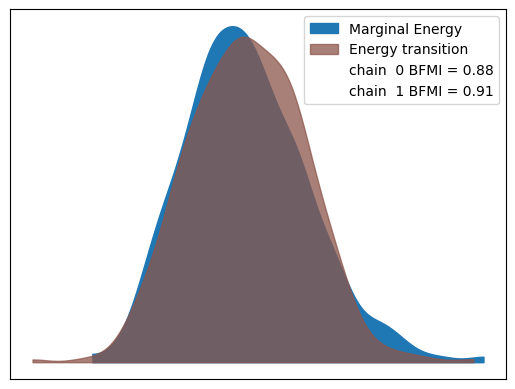

In [20]:
az.plot_energy(idataNutpie)

In [21]:
var_names_list = [
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ]

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center': 'sigma_u1'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_1'}>],
       [<Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'c2_2'}>],
       [<Axes: title={'center': 'sigma_u2'}>,

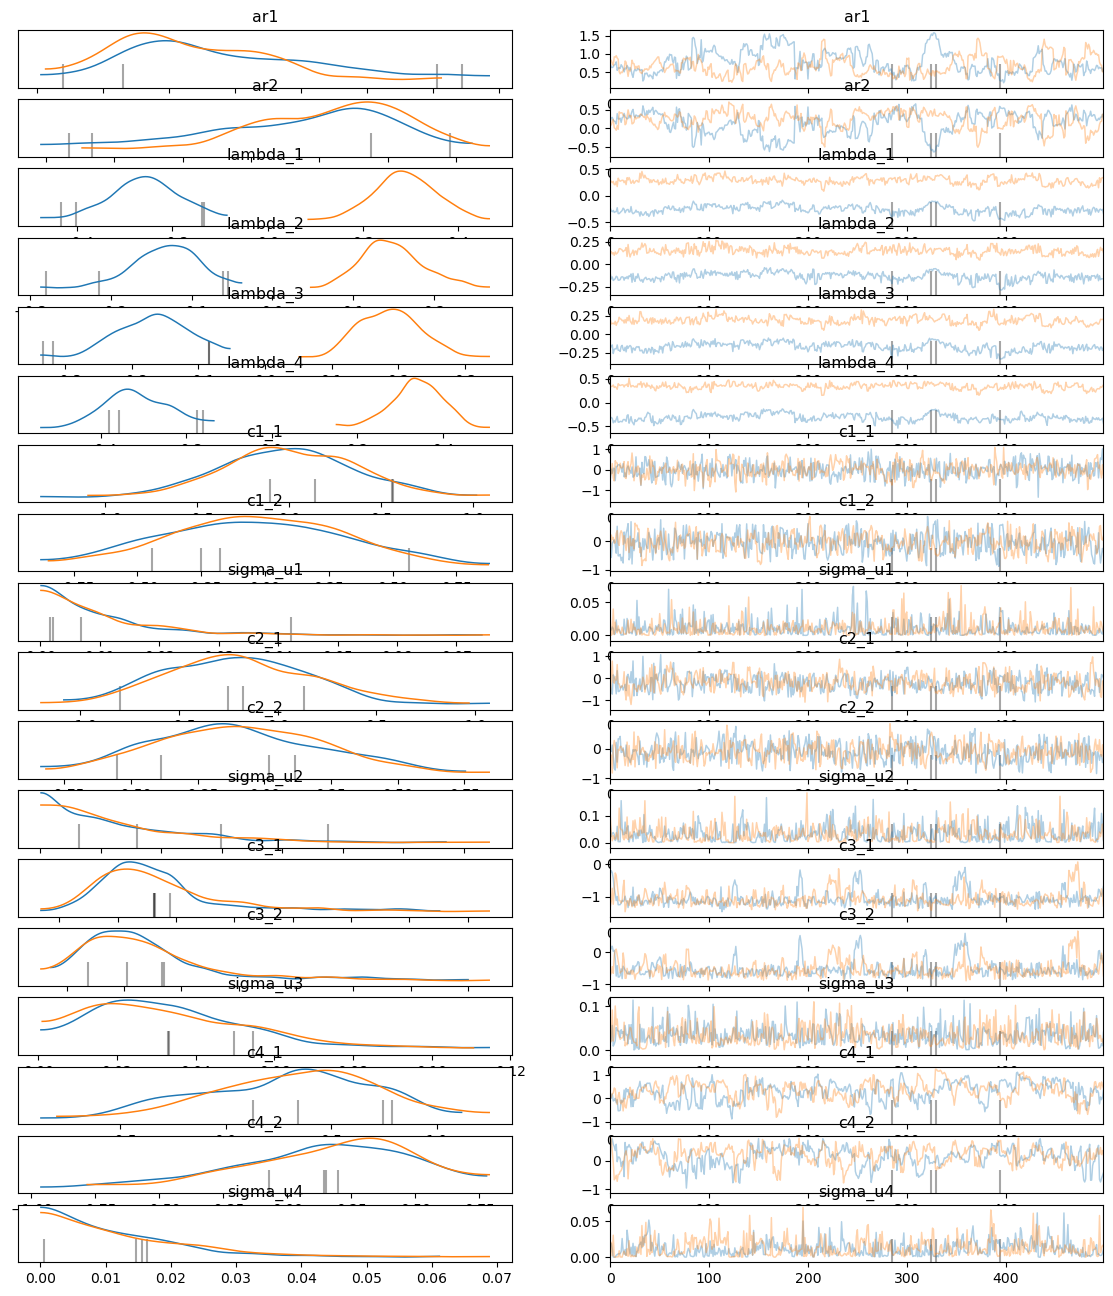

In [22]:
az.plot_trace(
    idataNutpie,
    var_names=var_names_list,
    figsize=(14, 16),
    compact=False
)

In [24]:
az.summary(idataNutpie, var_names=var_names_list)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar1,0.724,0.283,0.236,1.241,0.052,0.024,40.0,89.0,1.06
ar2,0.176,0.265,-0.328,0.639,0.046,0.023,43.0,93.0,1.06
lambda_1,0.014,0.283,-0.372,0.397,0.194,0.010,3.0,30.0,1.88
lambda_2,0.007,0.148,-0.191,0.238,0.101,0.005,3.0,64.0,1.87
lambda_3,0.009,0.186,-0.252,0.267,0.126,0.007,3.0,51.0,1.89
lambda_4,0.012,0.334,-0.407,0.443,0.230,0.007,3.0,79.0,1.85
c1_1,-0.002,0.362,-0.664,0.668,0.014,0.011,710.0,720.0,1.00
c1_2,-0.039,0.340,-0.632,0.628,0.014,0.009,595.0,520.0,1.00
sigma_u1,0.011,0.012,0.000,0.033,0.000,0.001,744.0,482.0,1.01
c2_1,-0.202,0.366,-0.866,0.455,0.016,0.010,536.0,463.0,1.00


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

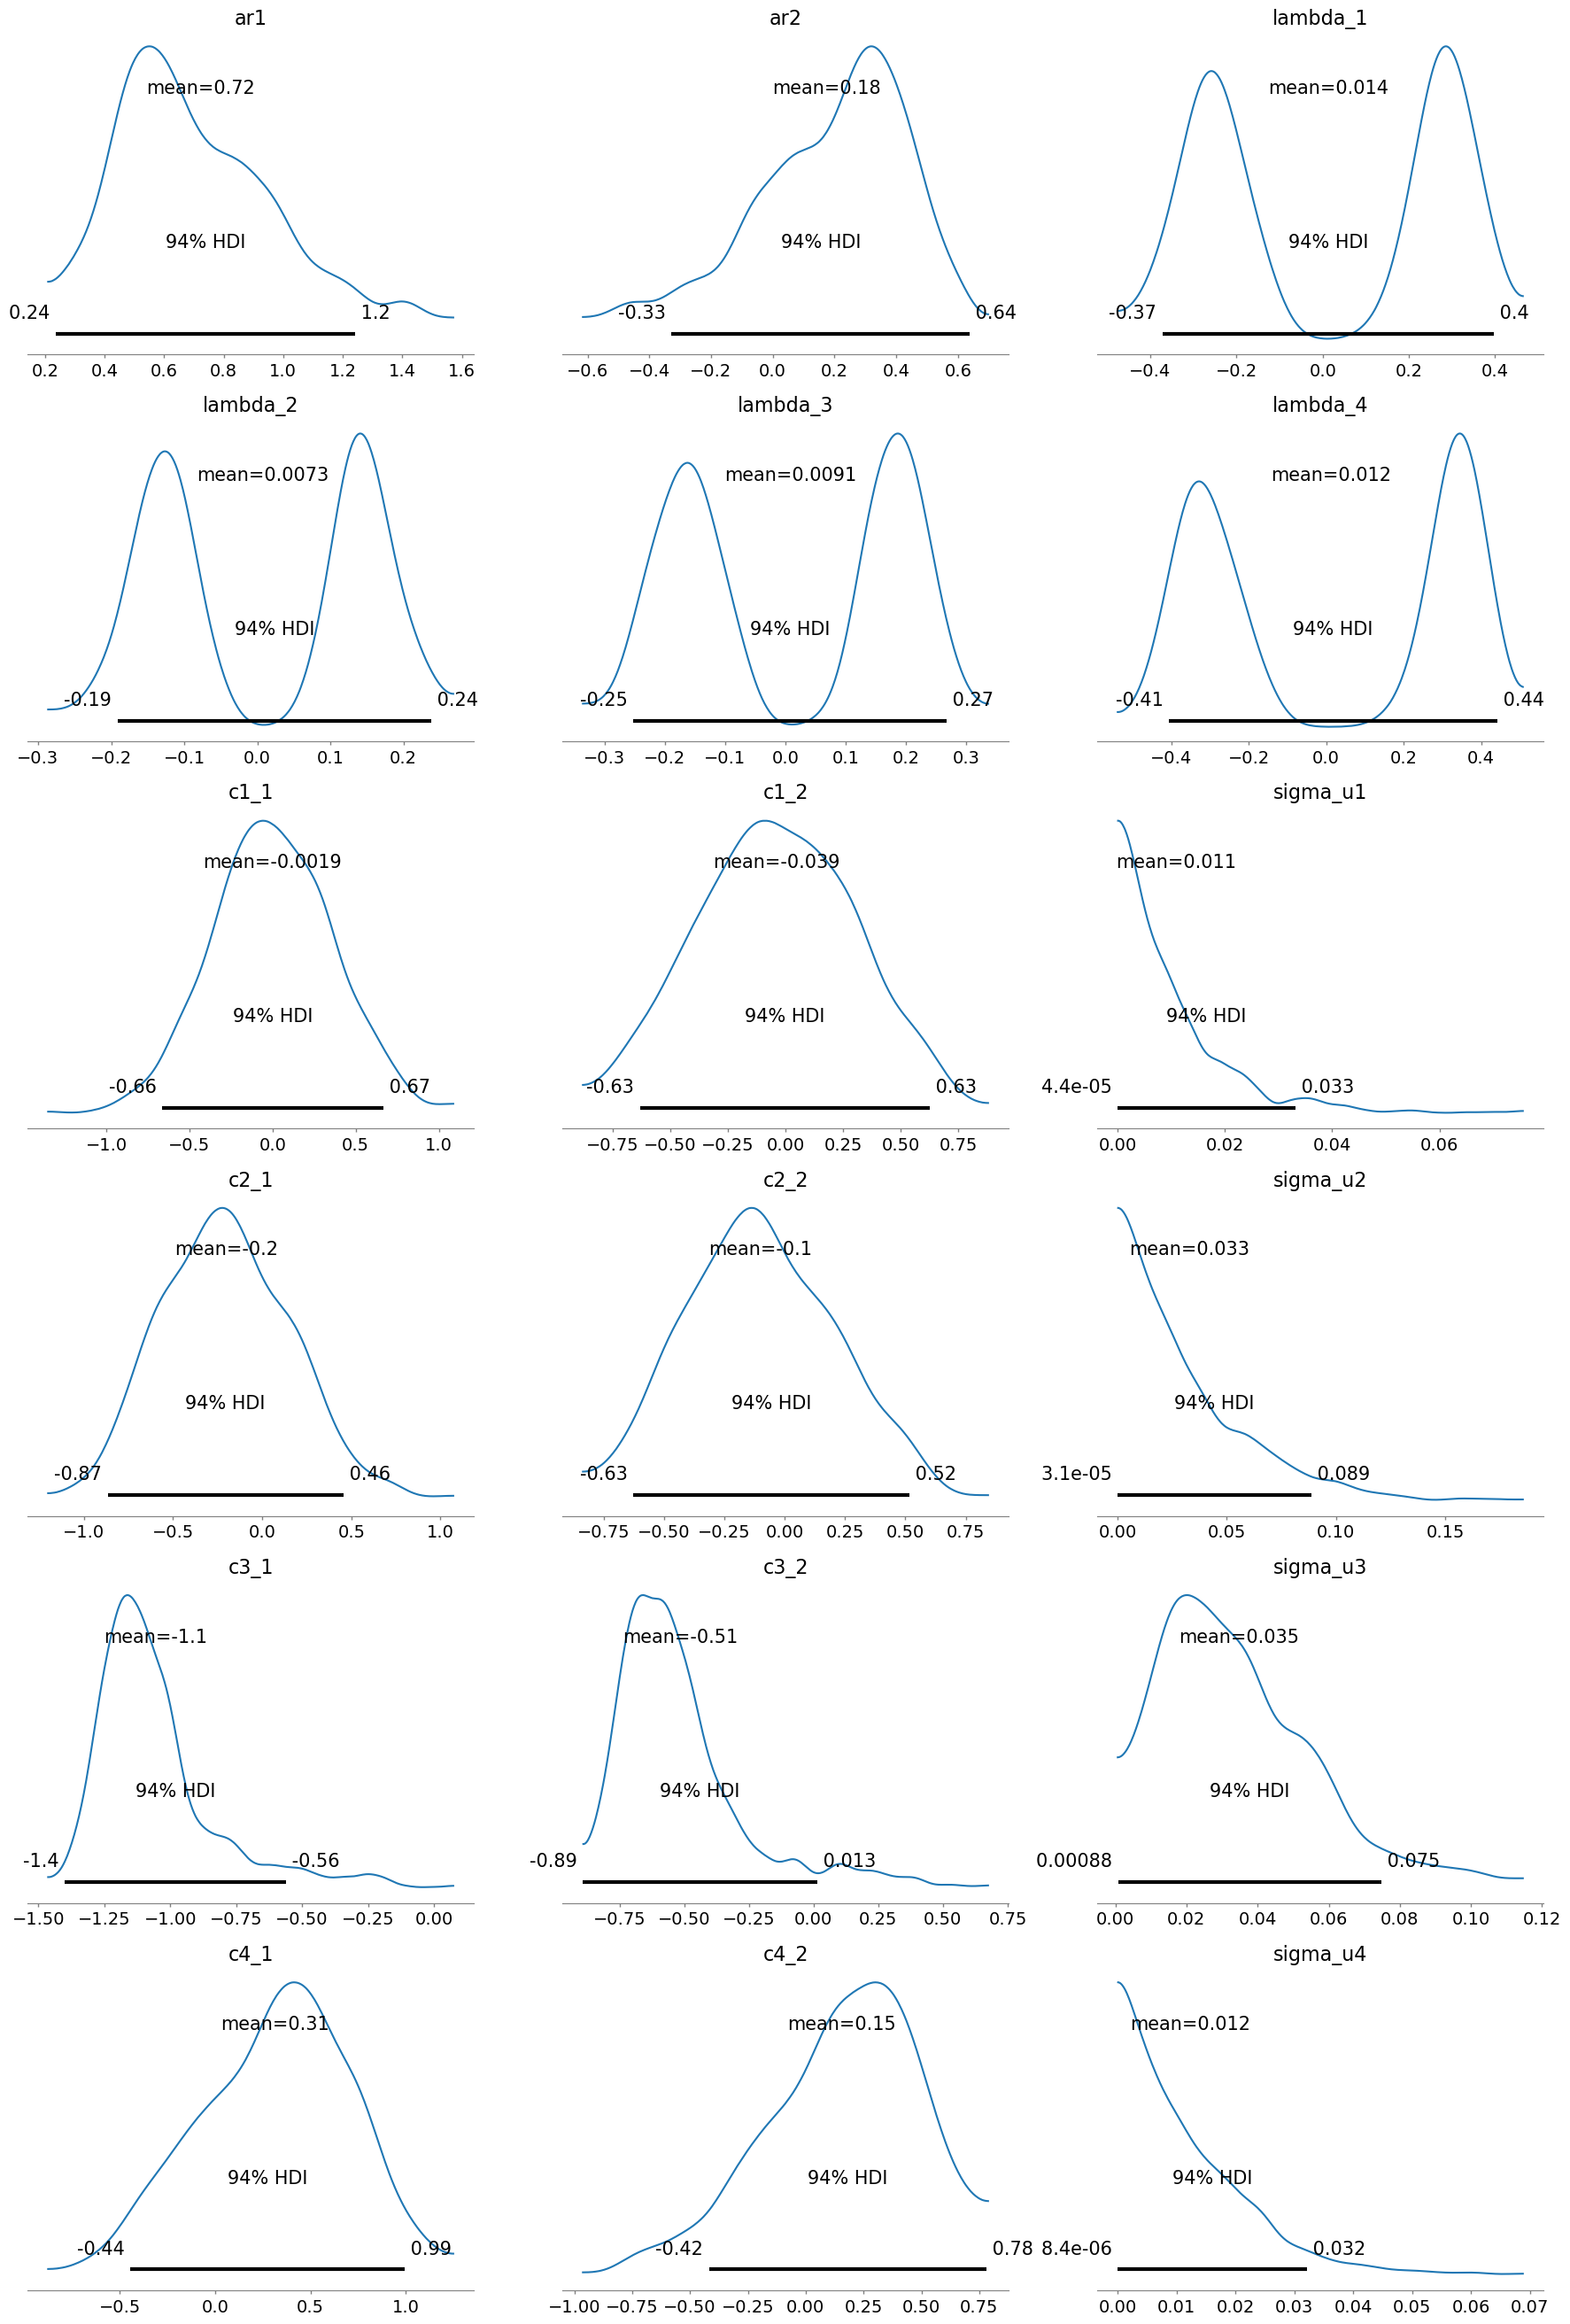

In [25]:
az.plot_posterior(
    idataNutpie,
    var_names=var_names_list,  
)

In [27]:
with pm.Model() as index_mod:
    coincident_dfm._build_dummy_graph()
    coincident_dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = coincident_dfm.unpack_statespace()

    design = Z
    print(design)
    transition = T
    coincident_dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariance"]

    # attention to the order
    
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T   
        return K

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    
    k_states = T.shape[0]

    W1 = pt.linalg.inv(
        pt.eye(k_states)
        - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())
    print(factor_mean.shape)

    pm.Deterministic("factor_mean", factor_mean)
    factor_mean_idata=pm.sample_posterior_predictive(idataNutpie, var_names=["factor_mean"])




design
Shape.0


Sampling: []


Output()

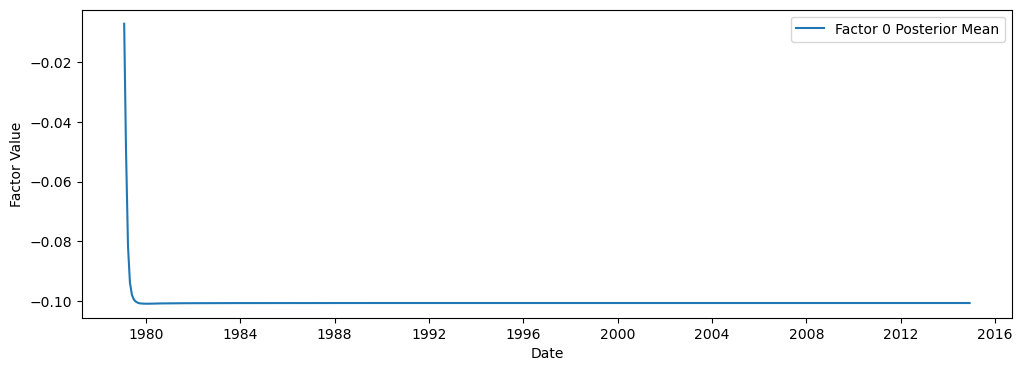

In [29]:
import matplotlib.pyplot as plt

# Extract posterior predictive samples
factor_samples = factor_mean_idata.posterior_predictive["factor_mean"].values  # shape: (2, 500, 10, 431)

# Select the first factor (index 0)
factor_0_samples = factor_samples[:, :, 0, :]  # shape: (2, 500, 431)

# Average over chains and draws to get posterior mean for each time point
factor_0_mean = factor_0_samples.mean(axis=(0, 1))  # shape: (431,)

# Get the time index from your observed data for x-axis
dates = factor_mean_idata.observed_data.time.values  # array of datetime64

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, factor_0_mean, label="Factor 0 Posterior Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Factor Value")
ax.legend()
plt.show()

lower = np.percentile(factor_0_samples, 2.5, axis=(0, 1))
upper = np.percentile(factor_0_samples, 97.5, axis=(0, 1))

ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI")


## Using Nutpie estimation 2

In [30]:
idataNutpie = az.from_netcdf("SampleNutpie2.nc")

<Axes: >

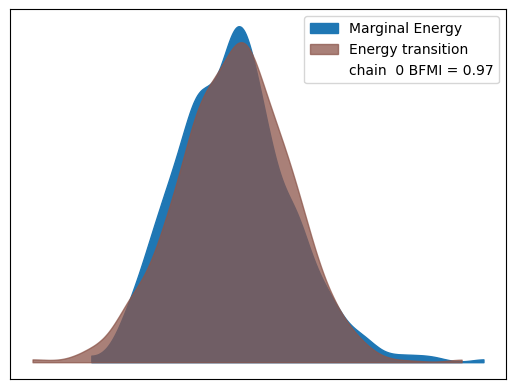

In [31]:
az.plot_energy(idataNutpie)

In [32]:
var_names_list = [
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ]

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center': 'sigma_u1'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_1'}>],
       [<Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'c2_2'}>],
       [<Axes: title={'center': 'sigma_u2'}>,

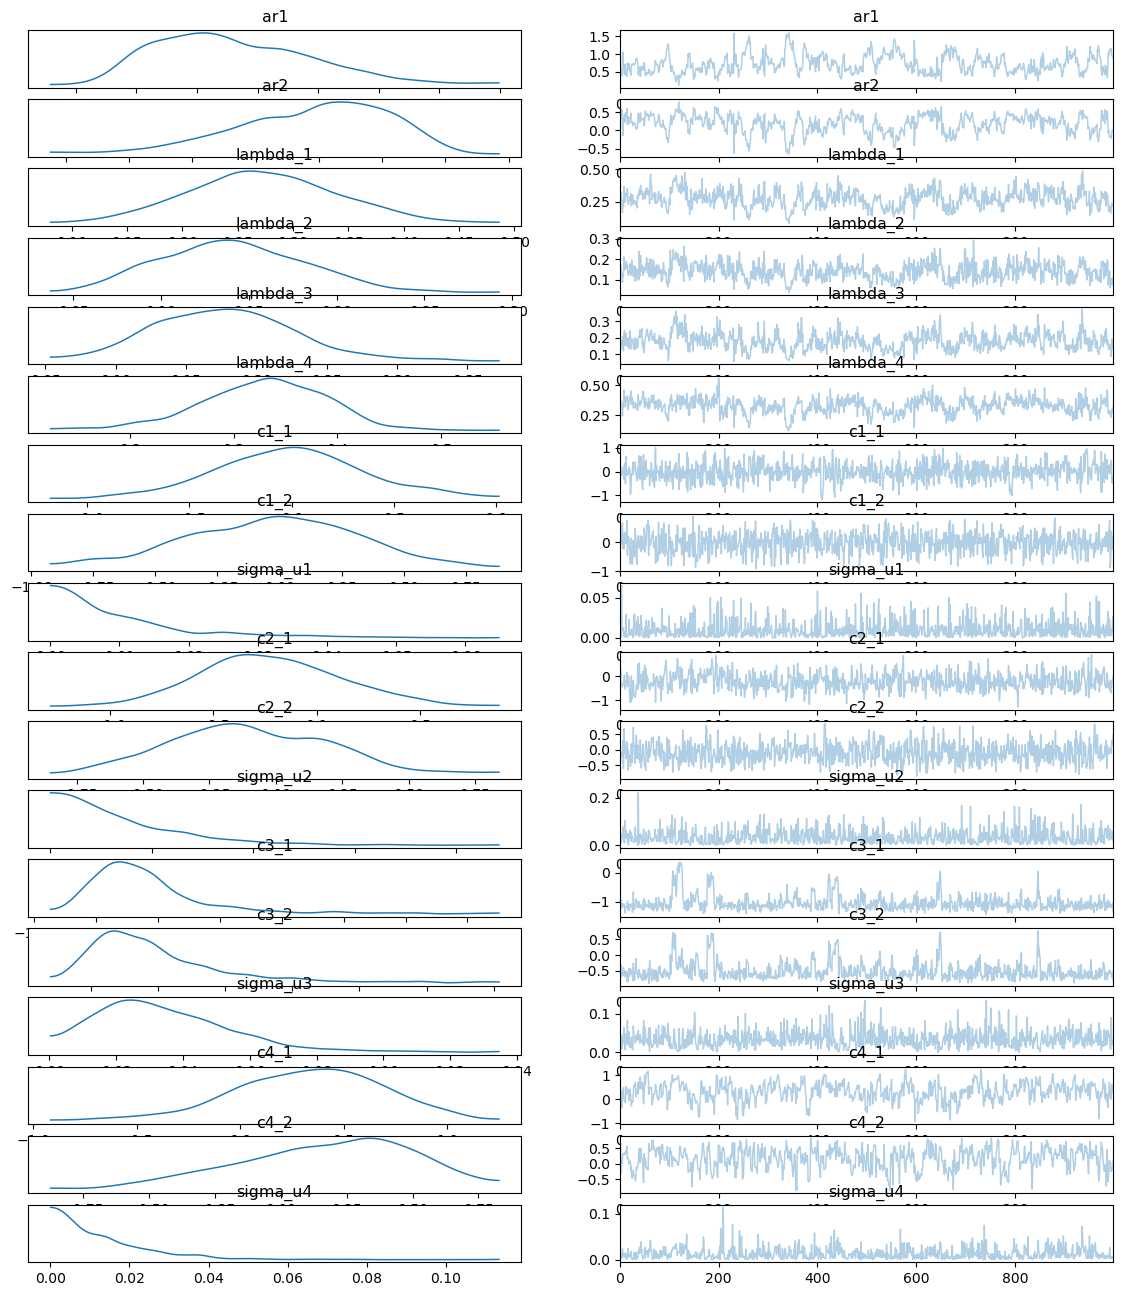

In [33]:
az.plot_trace(
    idataNutpie,
    var_names=var_names_list,
    figsize=(14, 16),
    compact=False
)

In [35]:
az.summary(idataNutpie, var_names=var_names_list)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar1,0.722,0.258,0.292,1.173,0.031,0.016,71.0,146.0,NaN
ar2,0.179,0.241,-0.275,0.564,0.030,0.015,66.0,151.0,NaN
lambda_1,0.273,0.067,0.147,0.396,0.007,0.003,105.0,156.0,NaN
lambda_2,0.140,0.041,0.073,0.219,0.003,0.002,136.0,211.0,NaN
lambda_3,0.178,0.051,0.089,0.282,0.005,0.002,112.0,168.0,NaN
lambda_4,0.328,0.062,0.198,0.426,0.007,0.004,79.0,182.0,NaN
c1_1,-0.010,0.378,-0.741,0.735,0.014,0.014,745.0,512.0,NaN
c1_2,-0.030,0.348,-0.825,0.509,0.011,0.009,959.0,838.0,NaN
sigma_u1,0.010,0.010,0.000,0.031,0.000,0.000,740.0,465.0,NaN
c2_1,-0.223,0.349,-0.839,0.473,0.017,0.010,413.0,333.0,NaN


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

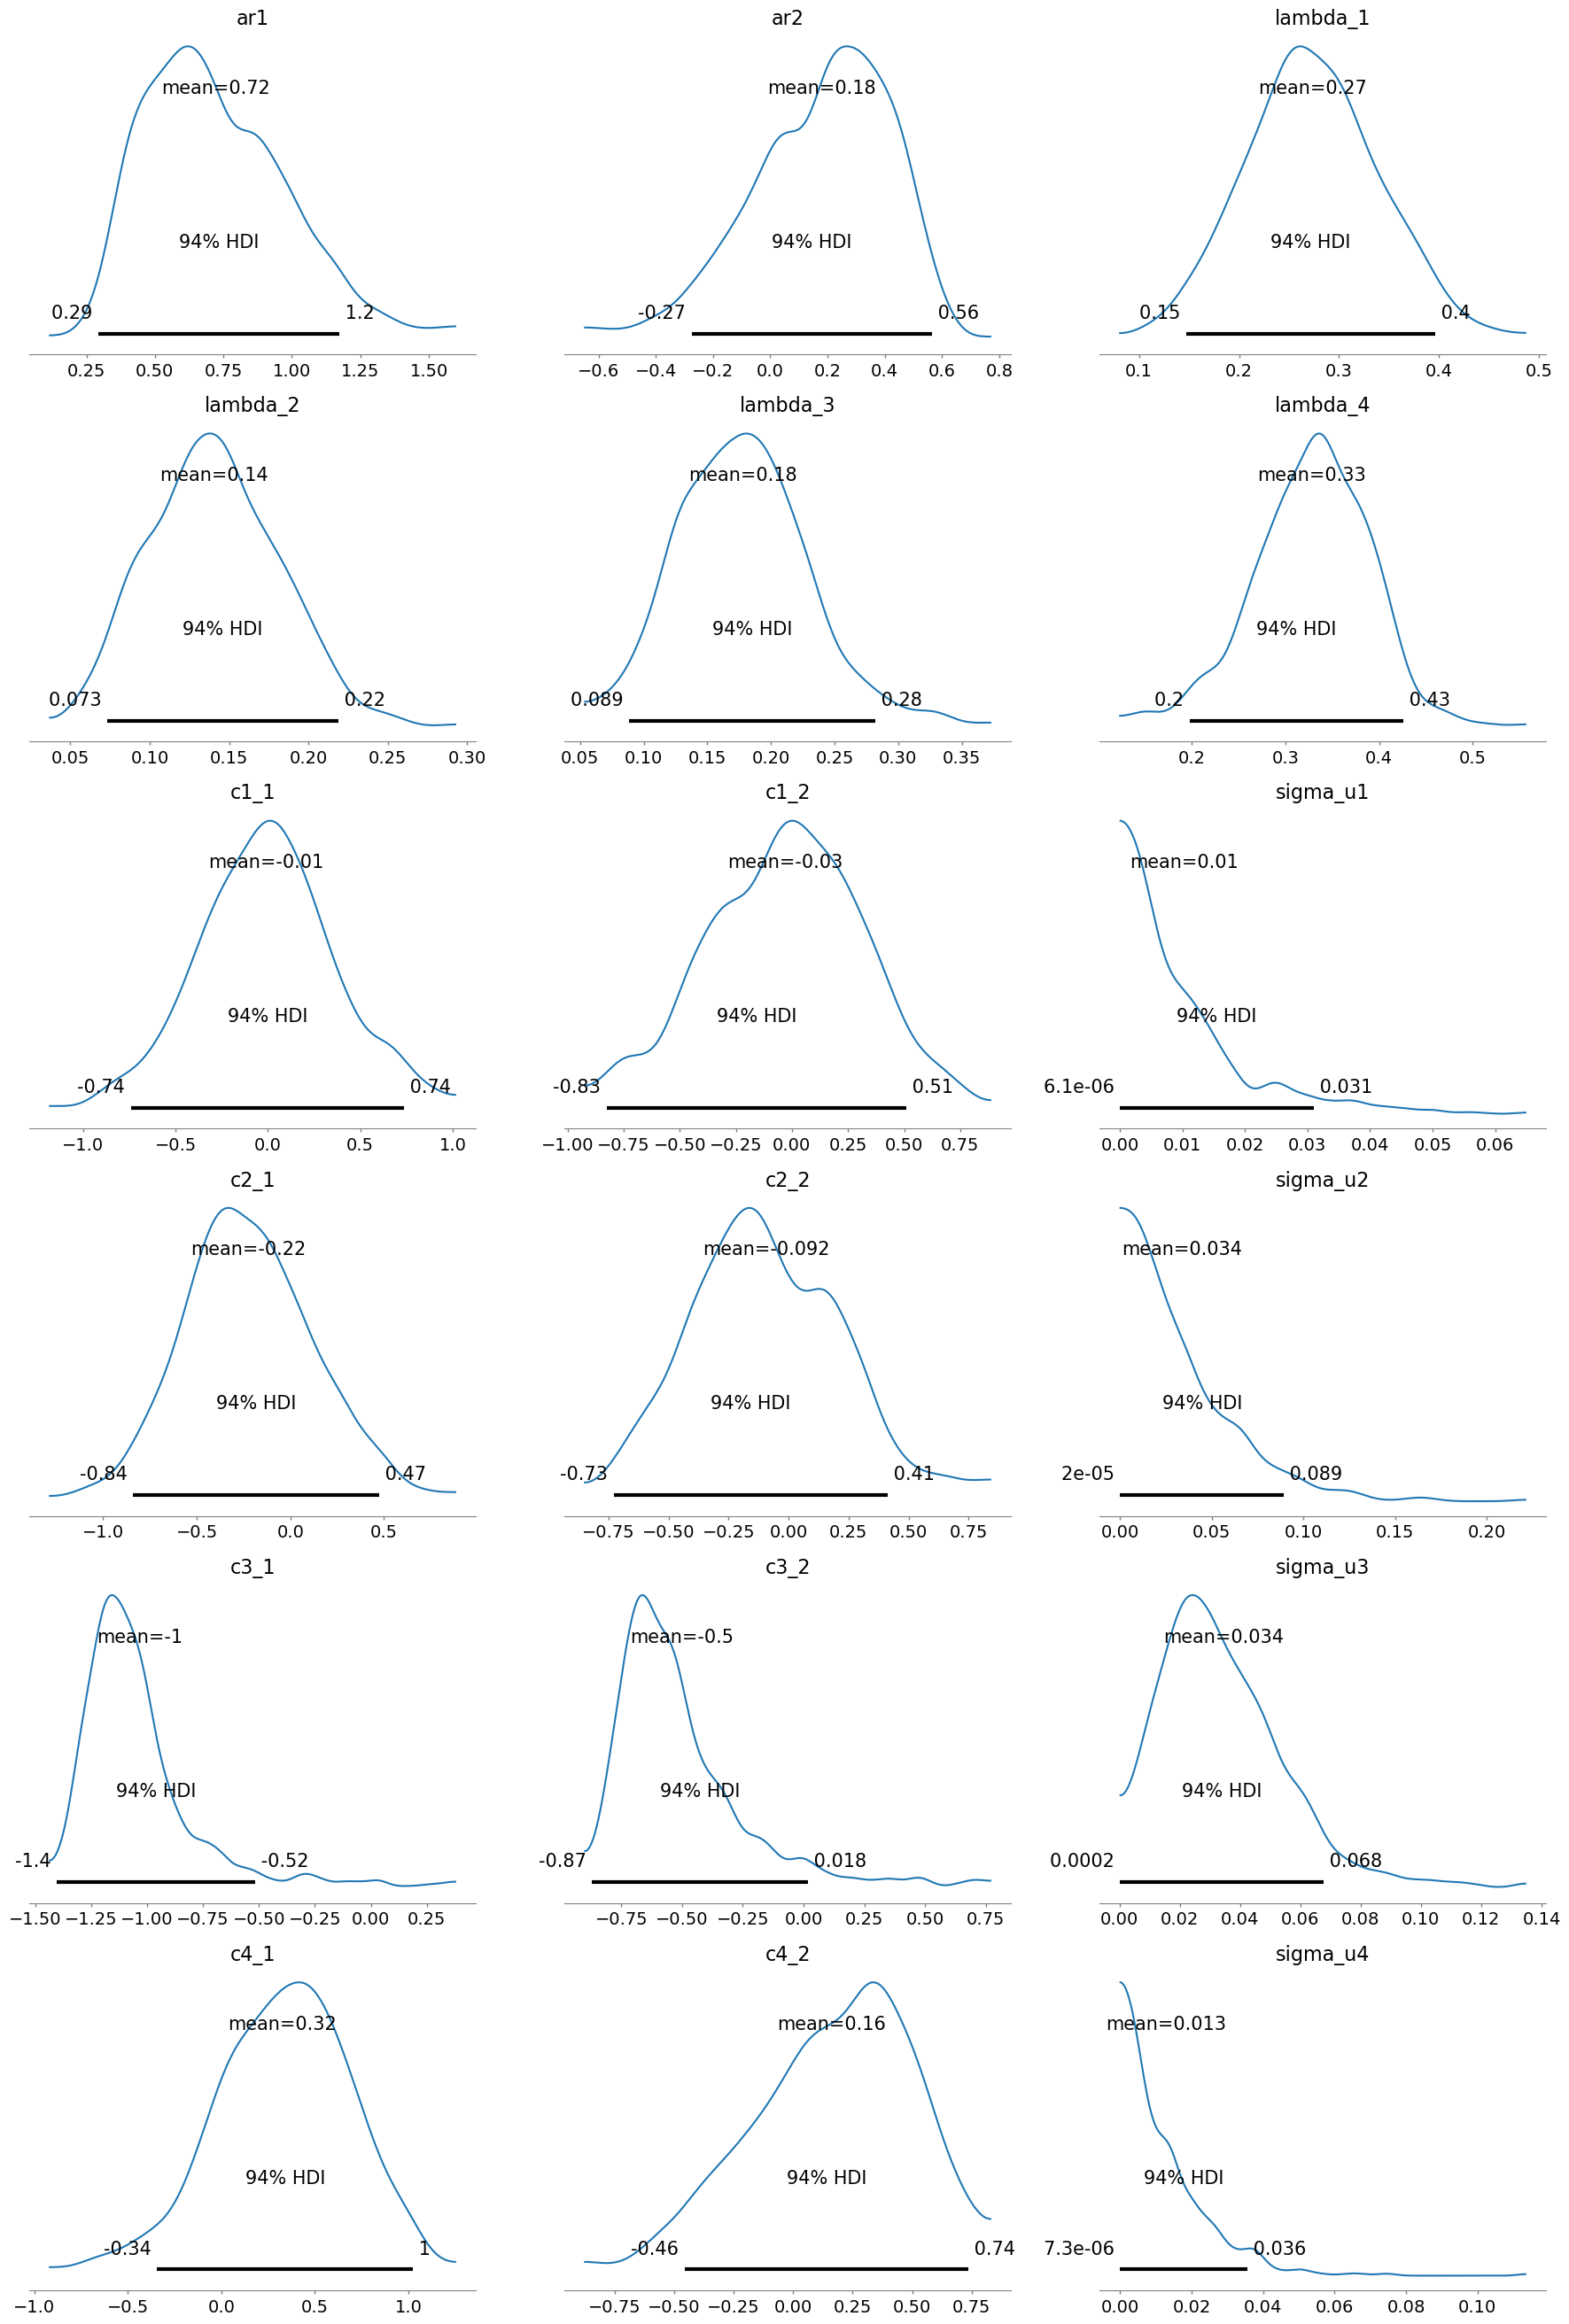

In [36]:
az.plot_posterior(
    idataNutpie,
    var_names=var_names_list,  
)

In [38]:
with pm.Model() as index_mod:
    coincident_dfm._build_dummy_graph()
    coincident_dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = coincident_dfm.unpack_statespace()

    design = Z
    print(design)
    transition = T
    coincident_dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariance"]

    # attention to the order
    
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T   
        return K

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    
    k_states = T.shape[0]

    W1 = pt.linalg.inv(
        pt.eye(k_states)
        - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())
    print(factor_mean.shape)

    pm.Deterministic("factor_mean", factor_mean)
    factor_mean_idata=pm.sample_posterior_predictive(idataNutpie, var_names=["factor_mean"])




design
Shape.0


Sampling: []


Output()

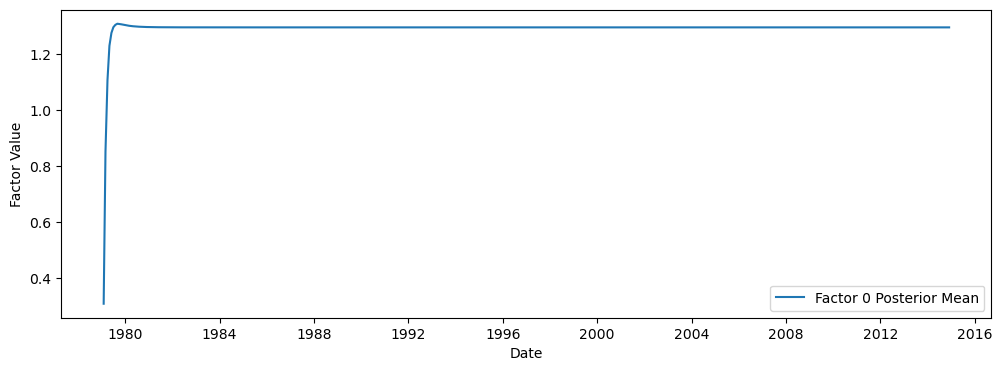

In [39]:
import matplotlib.pyplot as plt

# Extract posterior predictive samples
factor_samples = factor_mean_idata.posterior_predictive["factor_mean"].values  # shape: (2, 500, 10, 431)

# Select the first factor (index 0)
factor_0_samples = factor_samples[:, :, 0, :]  # shape: (2, 500, 431)

# Average over chains and draws to get posterior mean for each time point
factor_0_mean = factor_0_samples.mean(axis=(0, 1))  # shape: (431,)

# Get the time index from your observed data for x-axis
dates = factor_mean_idata.observed_data.time.values  # array of datetime64

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, factor_0_mean, label="Factor 0 Posterior Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Factor Value")
ax.legend()
plt.show()

lower = np.percentile(factor_0_samples, 2.5, axis=(0, 1))
upper = np.percentile(factor_0_samples, 97.5, axis=(0, 1))

ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI")


### Using Laplace estimation

In [43]:
import pymc_extras as pmx

In [42]:
coincident_dfm  = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    coincident_dfm.build_statespace_graph(data=endog, mode="jax")
    idata= pmx.fit_laplace(compile_kwargs={'mode':'JAX'} ,
                            gradient_backend='jax')
    
    # idata = pm.sample(
    #   draws=500,
    #    chains=2,
    #    nuts_sampler="nutpie",
    #    nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    # )

Output()

Output()

In [19]:
#idata.to_netcdf("SampleLaplace.nc")

'LaplaceModel.nc'

In [40]:
idataLaplace = az.from_netcdf("SampleLaplace.nc")

In [44]:
var_names_list = [
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ]

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center': 'sigma_u1'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_1'}>],
       [<Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'c2_2'}>],
       [<Axes: title={'center': 'sigma_u2'}>,

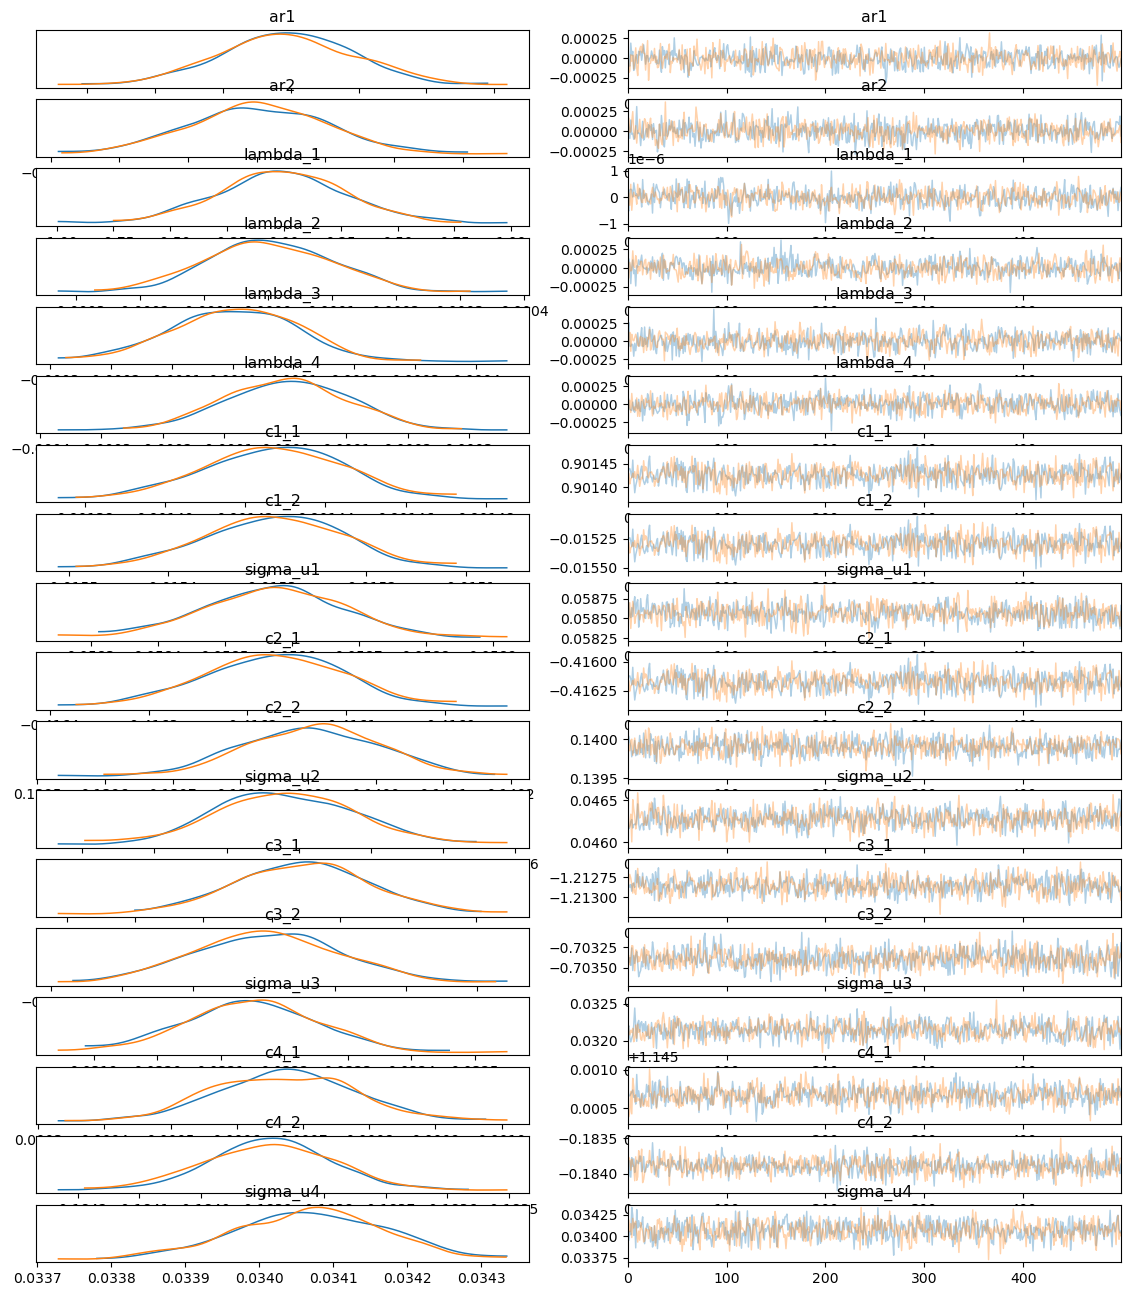

In [45]:
az.plot_trace(
    idataLaplace,
    var_names=var_names_list,
    figsize=(14, 16),
    compact=False
)

In [46]:
az.summary(idataLaplace, var_names=var_names_list)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar1,-0.000,0.0,-0.000,0.000,0.0,0.0,1062.0,831.0,1.00
ar2,0.000,0.0,-0.000,0.000,0.0,0.0,1034.0,833.0,1.00
lambda_1,-0.000,0.0,-0.000,0.000,0.0,0.0,881.0,823.0,1.00
lambda_2,0.000,0.0,-0.000,0.000,0.0,0.0,709.0,630.0,1.00
lambda_3,0.000,0.0,-0.000,0.000,0.0,0.0,893.0,930.0,1.00
lambda_4,0.000,0.0,-0.000,0.000,0.0,0.0,949.0,906.0,1.00
c1_1,0.901,0.0,0.901,0.901,0.0,0.0,902.0,778.0,1.00
c1_2,-0.015,0.0,-0.015,-0.015,0.0,0.0,902.0,778.0,1.00
sigma_u1,0.059,0.0,0.058,0.059,0.0,0.0,980.0,788.0,1.00
c2_1,-0.416,0.0,-0.416,-0.416,0.0,0.0,902.0,778.0,1.00


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

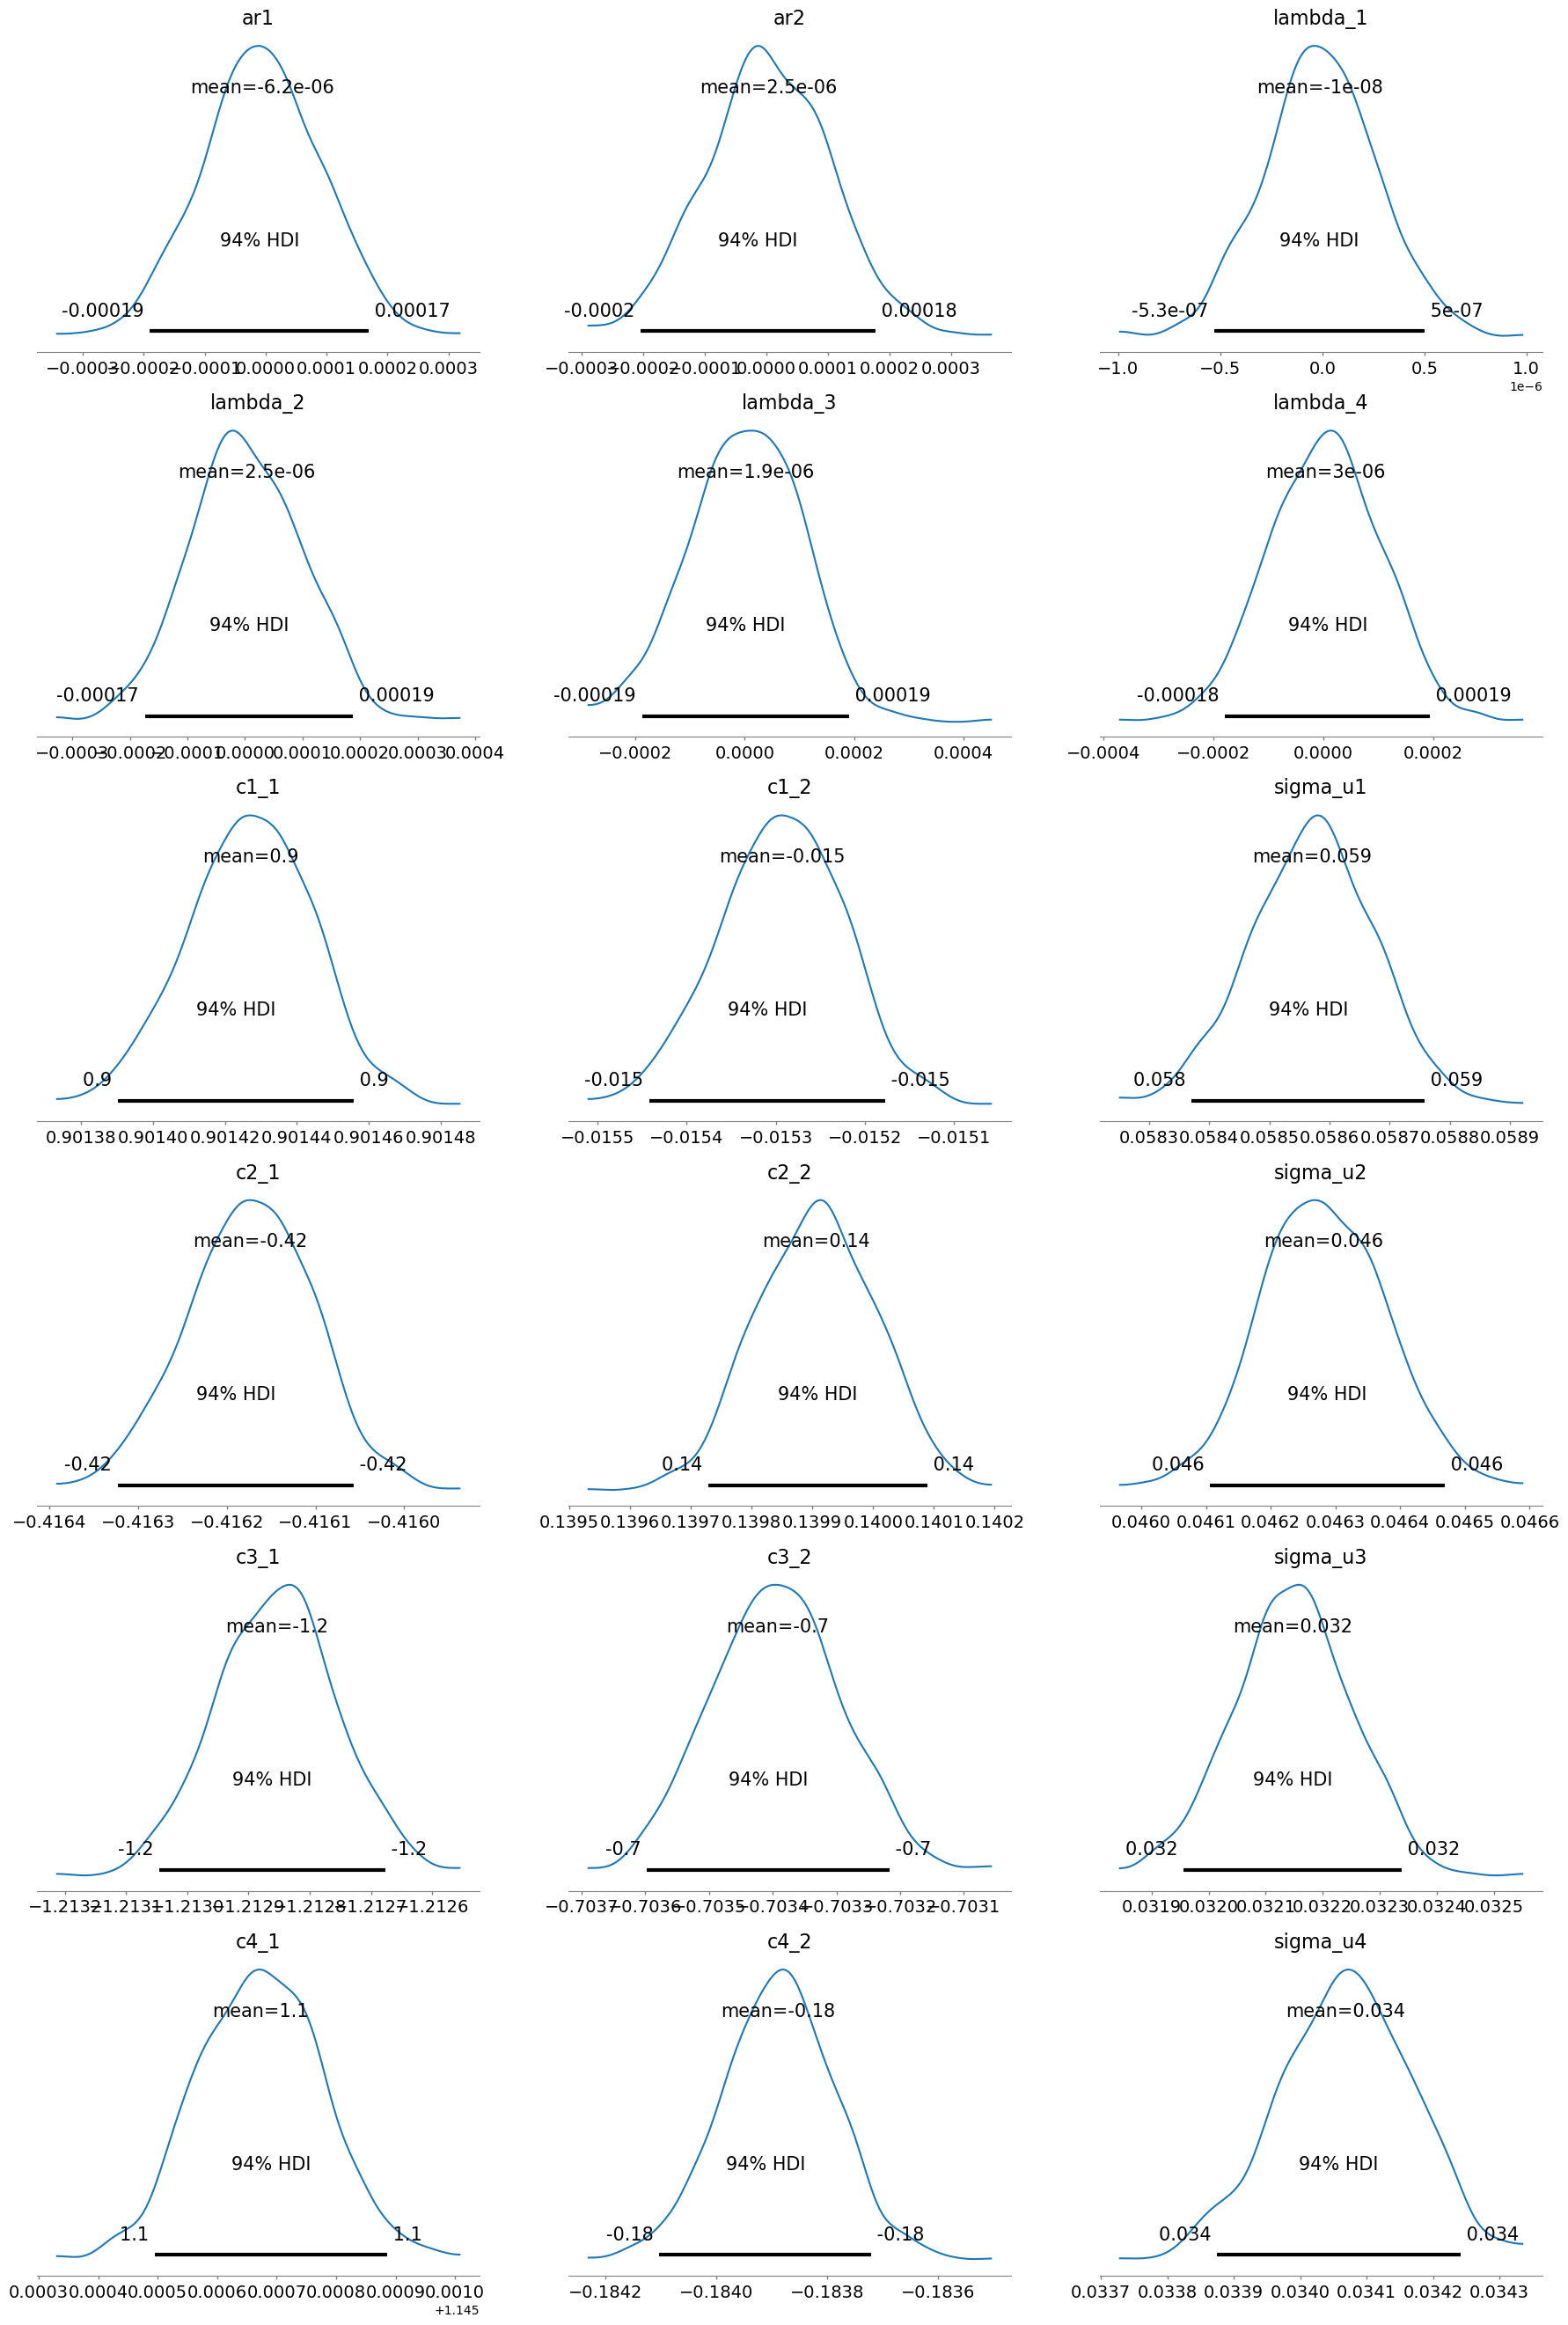

In [47]:
az.plot_posterior(
    idataLaplace,
    var_names=var_names_list,  
)

In [48]:
with pm.Model() as index_mod:
    coincident_dfm._build_dummy_graph()
    coincident_dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = coincident_dfm.unpack_statespace()

    design = Z
    print(design)
    transition = T
    coincident_dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariance"]

    # attention to the order
    
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T   
        return K

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    
    k_states = T.shape[0]

    W1 = pt.linalg.inv(
        pt.eye(k_states)
        - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())
    print(factor_mean.shape)

    pm.Deterministic("factor_mean", factor_mean)
    factor_mean_idata=pm.sample_posterior_predictive(idataLaplace, var_names=["factor_mean"])




design
Shape.0


Sampling: []


Output()

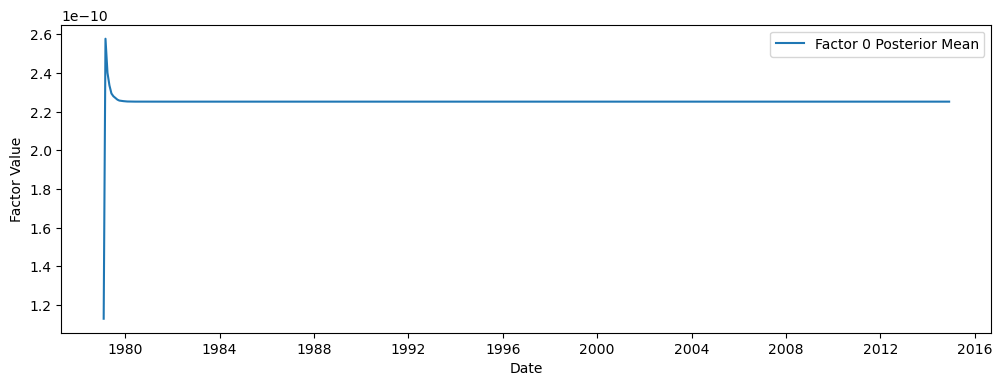

In [49]:
import matplotlib.pyplot as plt

# Extract posterior predictive samples
factor_samples = factor_mean_idata.posterior_predictive["factor_mean"].values  # shape: (2, 500, 10, 431)

# Select the first factor (index 0)
factor_0_samples = factor_samples[:, :, 0, :]  # shape: (2, 500, 431)

# Average over chains and draws to get posterior mean for each time point
factor_0_mean = factor_0_samples.mean(axis=(0, 1))  # shape: (431,)

# Get the time index from your observed data for x-axis
dates = factor_mean_idata.observed_data.time.values  # array of datetime64

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, factor_0_mean, label="Factor 0 Posterior Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Factor Value")
ax.legend()
plt.show()

lower = np.percentile(factor_0_samples, 2.5, axis=(0, 1))
upper = np.percentile(factor_0_samples, 97.5, axis=(0, 1))

ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI")


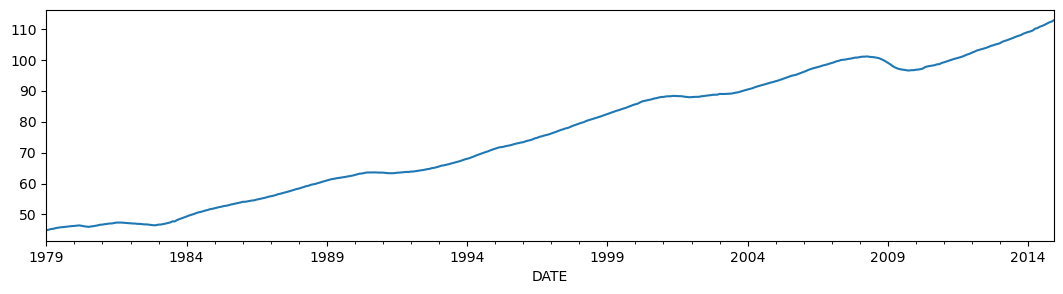

In [88]:
usphci = DataReader("USPHCI", "fred", start=start, end=end)["USPHCI"]
usphci.plot(figsize=(13, 3));

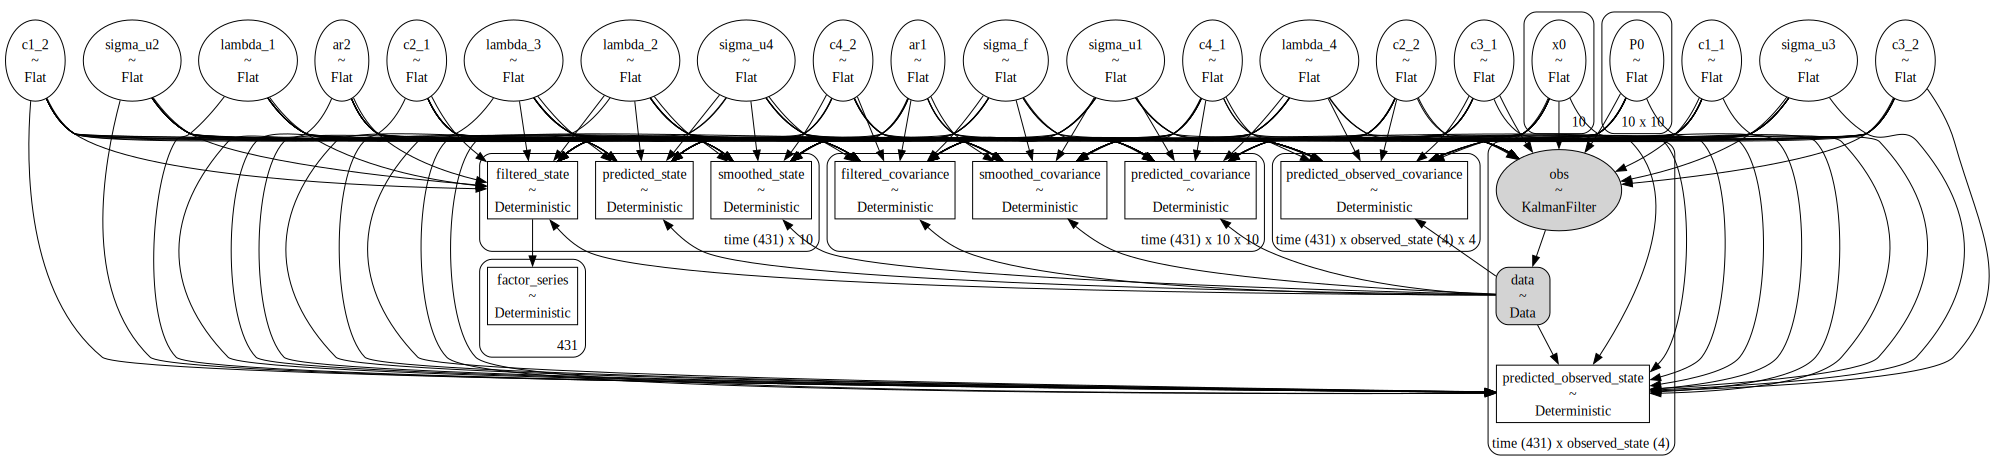

In [63]:
index_mod.to_graphviz()